In [48]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv('/bgfs/mrfrank/nolan/MAG/Data/Broad_MatchAffilNetwork.csv', index_col = 0)

/ihome/crc/install/python/ondemand-jupyter-python3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [51]:
#Country edges
edges = df.groupby(['Source matched country', 'Target matched country']).agg('count')[['Target ID']]\
.reset_index().rename(columns = {'Source matched country': 'Source country', 
                                 'Target matched country': 'Target country',
                     'Target ID': 'Count'})

edges

,Source country,Target country,Count
0,Algeria,Algeria,4
1,Algeria,Australia,11
2,Algeria,Austria,4
3,Algeria,Belarus,1
4,Algeria,Belgium,6
...,...,...,...
8068,Zimbabwe,USA,427
8069,Zimbabwe,Uganda,6
8070,Zimbabwe,United Kingdom,170
8071,Zimbabwe,Zambia,7


In [52]:
edges = edges[['Source Institution', 'Source country', 'Source region', 
               'Target Institution', 'Target country', 'Target region', 'Count']]
edges

KeyError: "['Source Institution', 'Target region', 'Source region', 'Target Institution'] not in index"

In [9]:
edges = edges.dropna()

In [54]:
crdf = pd.read_csv('/bgfs/mrfrank/nolan/MAG/Data/CountryRegionPairs.csv')
crdf

,Country,Region
0,Bangladesh,Asia
1,Bhutan,Asia
2,Brunei,Asia
3,Cambodia,Asia
4,China,Asia
...,...,...
193,Samoa,Oceania
194,Solomon Islands,Oceania
195,Tonga,Oceania
196,Tuvalu,Oceania


In [55]:
edges = pd.merge(edges, crdf, left_on = 'Source country', right_on = 'Country').rename(columns = {'Region':'Source region'})
edges = pd.merge(edges, crdf, left_on = 'Target country', right_on = 'Country').rename(columns = {'Region':'Target region'})

In [56]:
edges

,Source country,Target country,Count,Country_x,Source region,Country_y,Target region
0,Algeria,Algeria,4,Algeria,MENA,Algeria,MENA
1,Australia,Algeria,1,Australia,Oceania,Algeria,MENA
2,Brazil,Algeria,2,Brazil,South America,Algeria,MENA
3,China,Algeria,6,China,Asia,Algeria,MENA
4,India,Algeria,1,India,Asia,Algeria,MENA
...,...,...,...,...,...,...,...
7178,United Arab Emirates,Panama,1,United Arab Emirates,MENA,Panama,Central America
7179,United Kingdom,Panama,1,United Kingdom,Europe,Panama,Central America
7180,Russia,Iraq,1,Russia,Europe,Iraq,MENA
7181,South Korea,Iraq,1,South Korea,Asia,Iraq,MENA


In [57]:
edges = edges.drop(['Country_x', 'Country_y'], axis = 1)
edges = edges[['Source country', 'Source region', 'Target country', 'Target region', 'Count']]
edges

,Source country,Source region,Target country,Target region,Count
0,Algeria,MENA,Algeria,MENA,4
1,Australia,Oceania,Algeria,MENA,1
2,Brazil,South America,Algeria,MENA,2
3,China,Asia,Algeria,MENA,6
4,India,Asia,Algeria,MENA,1
...,...,...,...,...,...
7178,United Arab Emirates,MENA,Panama,Central America,1
7179,United Kingdom,Europe,Panama,Central America,1
7180,Russia,Europe,Iraq,MENA,1
7181,South Korea,Asia,Iraq,MENA,1


In [201]:
G = nx.DiGraph()

In [202]:
G.add_weighted_edges_from(list(zip(edges['Source country'], edges['Target country'], edges['Count'])))

In [23]:
edges.sort_values('Count', ascending = False)

,Source country,Source region,Target country,Target region,Count
3175,USA,North America,USA,North America,2280645
3179,United Kingdom,Europe,USA,North America,391587
3359,United Kingdom,Europe,United Kingdom,Europe,277931
3355,USA,North America,United Kingdom,Europe,263429
3098,Canada,North America,USA,North America,217364
...,...,...,...,...,...
2939,Malawi,Sub-Saharan Africa,Taiwan,Asia,1
2933,Kenya,Sub-Saharan Africa,Taiwan,Asia,1
4709,Malawi,Sub-Saharan Africa,Israel,MENA,1
6386,Hungary,Europe,Ethiopia,Sub-Saharan Africa,1


In [210]:
#cd = instcr.set_index('Institution').to_dict()['Country']
cr = crdf.set_index('Country').to_dict()['Region']

In [211]:
#nx.set_node_attributes(Gs, cd, 'Country')
nx.set_node_attributes(G, cr, 'Region')

In [204]:
bigcountries = dict()
for k, v in nx.get_edge_attributes(G, 'weight').items():
    if k[1] in bigcountries:
        #print(k)
        bigcountries[k[1]] += v
    else:
        bigcountries[k[1]] = v
bigcountries = sorted(bigcountries.items(), key = lambda x: x[1], reverse = True)
bigcountries = {x[0]:x[0] for x in bigcountries[:25]}

In [209]:
G = G.subgraph(bigcountries.values())

In [213]:
ordregions = [u[1] for u in G.nodes(data="Region")]

In [291]:
nodecolors = {"North America":"red", "Europe" : "blue", 
            "Asia": "darkgreen", "Sub-Saharan Africa" : "orange", 
            "MENA" : "#660000", 
            #"MENA" = '#934C4C', #lighter shade
            "Oceania" : "#A6A6ED", 
            "South America" : "#FF00FF", "Central America" : "#008080"
         }

In [215]:
import sys
def flushprint(w):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % w)
    sys.stdout.flush()

In [292]:
collist = []
i = 0
for reg in ordregions:
    collist.append(nodecolors[reg])
    i += 1
    flushprint(i)
#colors['North America']

25

In [218]:
colors = list(nx.get_edge_attributes(G, 'weight').values())

In [306]:
nodelists = []
regs = ['North America', 'Asia', 'Europe', 'Oceania', 'South America', 'Sub-Saharan Africa', 'Central America']
for reg in regs:
    reglist = []
    for n in G.nodes:
        if G.nodes[n]['Region'] == reg:
            reglist.append(n)
    nodelists.append(reglist)
        

In [270]:
pos = nx.spring_layout(G, k = 1)

<ipython-input-347-86d748e8e47a>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_facecolor('k')


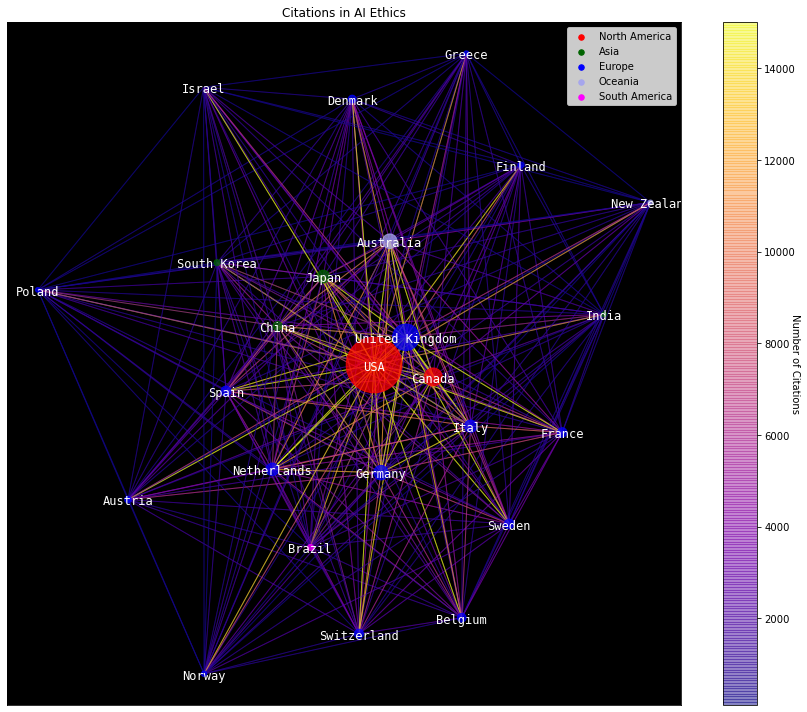

<Figure size 432x288 with 0 Axes>

In [347]:
plt.figure(1, figsize = (12, 10))
for nodelist in nodelists:
    if nodelist == []:
        continue
    nx.draw_networkx_nodes(G,
         pos,
         nodelist = nodelist,
         label = G.nodes[nodelist[0]]['Region'],
         #ax = ax,
         #with_labels = False,
         node_color = nodecolors[G.nodes[nodelist[0]]['Region']],
         node_size = [G.in_degree(n, weight = 'weight')/1500 for n in nodelist], 
         alpha = .75
)
nx.draw_networkx_labels(G, pos, font_color = 'white',labels = bigunis, verticalalignment = 'center_baseline',
                       font_family = 'monospace', font_weight = 'roman')
#i = 0
#for e in G.edges:
    
e = nx.draw_networkx_edges(G, 
               pos,
                           arrows = False,
               #ax = ax,
               edge_color = colors,
         edge_cmap = plt.cm.plasma,
         edge_vmin = min(colors),
         edge_vmax = 15000,
               #width=alpha * 5, 
                alpha= .5,
                connectionstyle=f'arc3, rad = .25')
#i += 1
# nx.draw_networkx_edge_labels(Gs, 
#                             pos,
#                             nx.get_edge_attributes(Gs, 'weight'))
#plt.scatter(0, 0, alpha = 0, c = nodecolors, label = 'Region')
ax = plt.gca()
plt.title('Citations in AI Ethics')
plt.axes().set_facecolor('k')
cbar = plt.colorbar(e)
cbar.set_label('Number of Citations', rotation = 270)
plt.legend(title = 'Region')
legend = ax.legend(frameon=True)
for legend_handle in legend.legendHandles:
    legend_handle.set_alpha(1)
    legend_handle._sizes = [30]
plt.tight_layout()
plt.show()
plt.savefig('InfoViz.png')

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not {'North America': 'red', 'Europe': 'blue', 'Asia': 'darkgreen', 'Sub-Saharan Africa': 'orange', 'MENA': '#660000', 'Oceania': '#A6A6ED', 'South America': '#FF00FF', 'Central America': '#008080'}

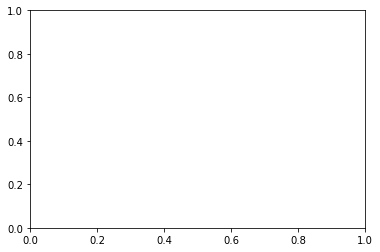

In [296]:
plt.scatter(0, 0, alpha = 0, c = nodecolors)